# Make a video animating the isotropic phase going off/on
### Written by Matan Yah Ben Zion 2020 10 16


## Steps

#### 1. Load linked trajectories of isotropic phase
#### 2. Plot trajectory ontop of frames and save animation


In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib.patches import Polygon


import pandas as pd
import time
import trackpy as tp
%matplotlib inline
def l2n(x): return np.asarray(x);
import numpy as np
import numba
from matplotlib import pyplot as plt
import matplotlib.animation as animation

from numba import njit
from scipy import interpolate
import pims
import os #for listing files in folder
import re #for parsing power from file name
import pdb

from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull




mpl.rc('text',usetex=True)
#plt.style.use('dark_background')
plt.style.use('default')
params = {'legend.fontsize': 22,
          'figure.figsize': (10, 8),
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'xtick.labelsize':22,
         'ytick.labelsize':22,
         'legend.fontsize':22,
         'legend.frameon':False,
         'xtick.top':False,
         'xtick.bottom':False,
         'ytick.left':False,
         'ytick.right':False,
         'ytick.labelsize':24,
         'xtick.labelsize':24,
         'image.cmap':'gray',
         'axes.labelsize':28};

plt.rcParams.update(params);


/Users/matan/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


# Load Data 

In [2]:
dirName = './'
fileName = 'frontersC0505med.tif'
fullPathName = dirName+'/'+fileName

originalVideoFPS= 5;
mpp = 0.1346154 #in this case, it is centimeters

#### Load video frames

In [3]:
#frames = pims.ImageReaderND(fileName)
frames = pims.TiffStack(fullPathName)

In [5]:
linkedFileName = 'C0505coppedTrimmedGray.MP4_linked20230110.csv'

t1 = pd.read_csv(linkedFileName)

In [6]:
#linkedFileName = 'C0505coppedTrimmedGray.MP4_located20230110.csv'
#df = pd.read_csv(linkedFileName)

# make the locating data a tracking data:
#df = pd.DataFrame({'x':df.x,'y':df.y,'frame':df.frame.astype(np.int16),'r':df.r})
#t = pd.DataFrame({'x':df.x,'y':df.y,'frame':df.frame.astype(np.int16),'r':df.r,'particle':[0]*len(df)})

# Save swimbys as animations

In [7]:
import matplotlib.patches as patches
import time

def plotScaleBar(ax,xy,width,height=0, mpp=0.163,color='w'):
    
    scaleBarText = str(width)+r' $\rm{cm}$';
    width = width/mpp;
    
    if (height ==0): 
        height = width/10;
    
    ax.add_patch(
    patches.Rectangle(
    xy,
    width,
    height,
    edgecolor = color,
    facecolor = color,
    fill=True
    ));
    textFontSize = 24;
    textX = xy[0]+width/2;
    textY = xy[1]+height+textFontSize;
    ax.text(textX,textY, scaleBarText,horizontalalignment='center',color=color,fontsize=textFontSize);

def plotTimeStamp(ax,xy,frame,fps,color='w'):
    textX = xy[0];
    textY = xy[1];
    
    timeStampText =  time.strftime('%M:%S',time.gmtime(frame/fps));
    textFontSize = 32;
    ax.text(textX,textY, timeStampText,horizontalalignment='center',color=color,fontsize=textFontSize);
    

In [8]:
def animateTracesOnImage(frm):
    
    ax.cla()
    
    traceColors = ['#ff7f0e', '#2ca02c','#1f77b4']#['r','g','b'];
    ax.imshow(frames[frm],vmin=0, vmax=255,cmap='gray')
    prtcls = tVideo.particle.unique();

    trackingFrame = frm*5 #when framerate  is different than video framerate
    cond = (np.max(trackingFrame-trailLength,0)<tVideo.frame) &(tVideo.frame<=trackingFrame)
    tVideoC = tVideo[cond];
    
    if(len(tVideoC)>0):
        #tp.plot_traj(tVideoC,ax = ax,plot_style={'linewidth':4,'color':'cyan','alpha':0.6})
        tp.plot_traj(tVideoC,ax = ax,plot_style={'linewidth':6,'alpha':0.4,'color':'pink','solid_capstyle':'round'})

    #if the printed frame is within the tracking draw a circle
    if len(tVideoC[tVideoC.frame==frm])>0:
        xF,yF,rF = tVideoC.x.values[-1],tVideoC.y.values[-1],tVideoC.r.values[-1]
        circleF = plt.Circle((xF, yF), rF, facecolor='none',edgecolor='pink',linewidth=4)
        ax.add_patch(circleF)
        
    plotScaleBar(ax,scaleBarXY,scaleBarWidth,mpp=mpp,color='k');
    plotTimeStamp(ax,timeStampXY,frm-minFrame,fps=originalVideoFPS,color='k');
    ax.axis('off')



In [9]:
#define scale bar
scaleBarWidth = 20;#[um]

frameWidth = frames[0].shape[0];
frameHeight = frames[0].shape[1];

scaleBarXY = (frameWidth-20-scaleBarWidth/mpp,frameHeight-40-scaleBarWidth/mpp/10);

timeStampXY = (50,50);

In [10]:
animationFileName = 'fronters_.mp4'
tVideo = t1.copy();
#tVideo.particle=0
#np.max([frameNum-history,0])


fps = 30
bitrate = 1800
figsize = 10
trailLength = 2000;
shiftStart = 380;


minFrame = 0#int(np.max([tVideo.frame.min()-trailLength,0]) + shiftStart)
maxFrame = int(np.min([tVideo.frame.max()+trailLength*2,len(frames)-45]))
frameStep = 5;

framesToShow = range(minFrame,maxFrame,frameStep);

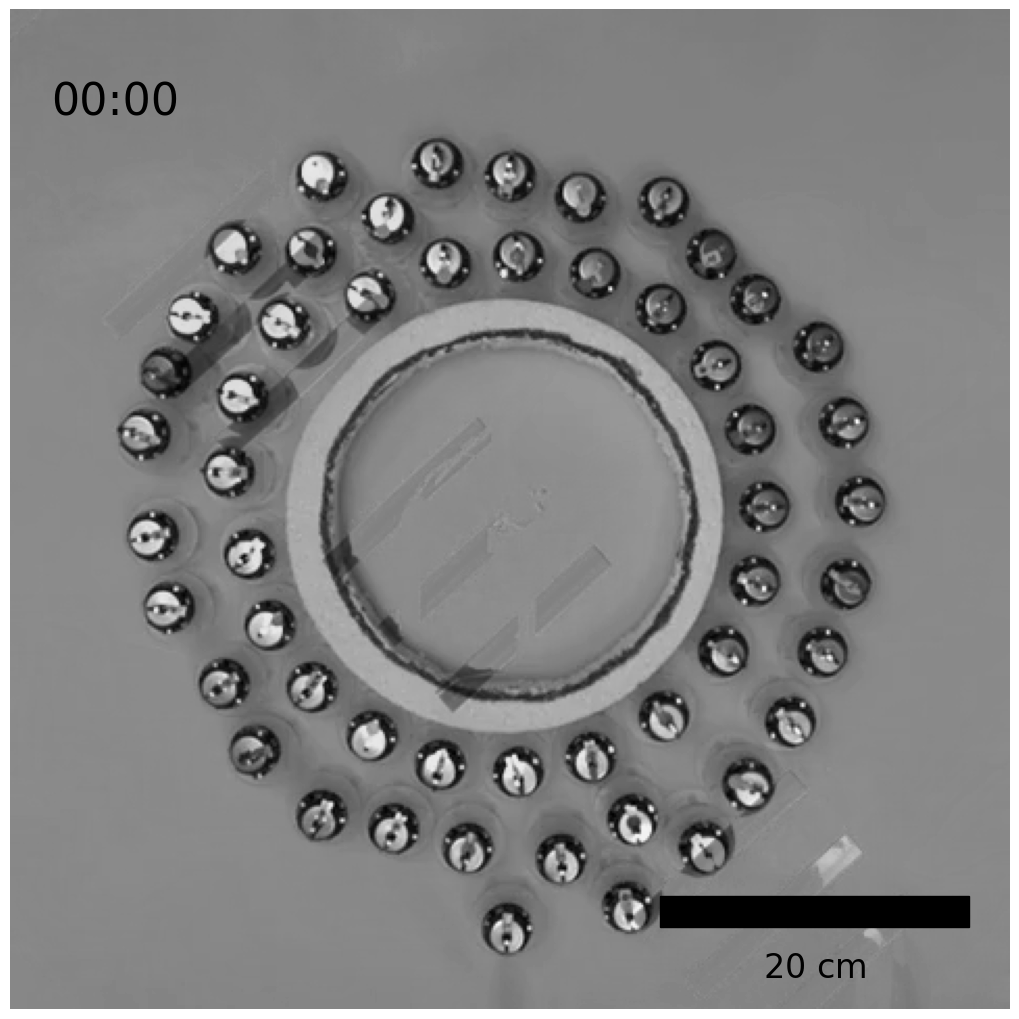

In [11]:
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=fps, metadata=dict(artist='MYBZ'), bitrate=bitrate)

fig,ax  = plt.subplots(figsize=(figsize,figsize),frameon=False)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
#makePolarColorMap(fig,cmap='hsv')


ani = mpl.animation.FuncAnimation(fig, animateTracesOnImage,frames=framesToShow);#, frames=datesToPlot, repeat=True)
ani.save(animationFileName, writer=writer)#,savefig_kwargs={'pad_inches':0,'bbox_inches':'tight'});
#,bbox_inches='tight', transparent="True", pad_inches=0)

In [14]:
t1.frame.max()

2038

In [27]:
imsd = tp.imsd(t1[t1.frame>500],mpp,25,max_lagtime=1300)

(1.0, 1000.0, 0.1, 10000.0)

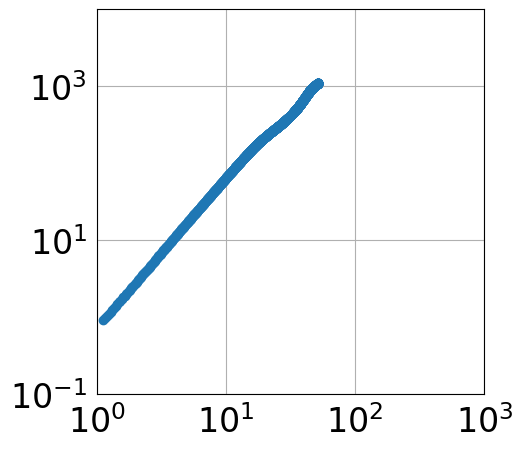

In [29]:
fig,ax = plt.subplots(figsize=(5,5))
ax.loglog(imsd[imsd.index>1.1],'o')
ax.grid()
ax.axis([1,1E3,1E-1,1E4])

In [30]:
imsd.to_csv(linkedFileName+'_imsd_.csv')